[原版（英文）图书地址](https://www.oreilly.com/library/view/feature-engineering-for/9781491953235/)

**翻译**：[apachecn](https://github.com/apachecn)，[翻译版本地址](https://github.com/apachecn/feature-engineering-for-ml-zh)

**代码修改和整理**：[黄海广](https://github.com/fengdu78)，原文修改成jupyter notebook格式，并增加和修改了部分代码，测试全部通过，所有数据集已经放在[百度云](data/README.md)下载。

# 六、降维：用 PCA 压缩数据集

> 译者：[@cn-Wziv](https://github.com/cn-Wziv)
> 
> 校对者：[@HeYun](https://github.com/KyrieHee)

通过自动数据收集和特征生成技术，可以快速获得大量特征，但并非所有这些都有用。在[第 3 章](https://www.safaribooksonline.com/library/view/feature-engineering-for/9781491953235/ch03.html#chap-basic-text)和
在[第 4 章](https://www.safaribooksonline.com/library/view/feature-engineering-for/9781491953235/ch04.html#chap-tfidf)中，我们讨论了基于频率的滤波和特征缩放修剪无信息的特征。现在我们来仔细讨论一下使用*主成分分析*（PCA）进行数据降维。

本章标志着进入基于模型的特征工程技术。在这之前，大多数技术可以在不参考数据的情况下定义。对于实例中，基于频率的过滤可能会说“删除所有小于`n`的计数“，这个程序可以在没有进一步输入的情况下进行数据本身。 另一方面，基于模型的技术则需要来自数据的信息。例如，PCA 是围绕数据的主轴定义的。 在之前的技术中，数据，功能和模型之间从来没有明确的界限。从这一点前进，差异变得越来越模糊。这正是目前关于特征学习研究的兴奋之处。

## 引言

降维是关于摆脱“无信息的信息”的同时保留关键点。有很多方法可以定义“无信息”。PCA 侧重于线性依赖的概念。在“[矩阵的剖析](https://www.safaribooksonline.com/library/view/feature-engineering-for/9781491953235/app01.html#sec-basic-linalg)”中，我们将数据矩阵的列空间描述为所有特征向量的跨度。如果列空间与特征的总数相比较小，则大多数特征是几个关键特征的线性组合。如果在下一步管道是一个线性模型，然后线性相关的特征会浪费空间和计算能力。为了避免这种情况，主成分分析尝试去通过将数据压缩成更低维的线性来减少这种“绒毛”子空间。

在特征空间中绘制一组数据点。每个数据点都是一个点，整个数据点集合形成一个 blob。在[图 6-1(a) ](https://www.safaribooksonline.com/library/view/feature-engineering-for/9781491953235/ch06.html#fig-data-blobs)中，数据点在两个特征维度上均匀分布，blob 填充空间。在这个示例中，列空间具有完整的等级。但是，如果其中一些特征是其他特征的线性组合，那么该 blob 看起来不会那么丰满; 它看起来更像[图 6-1(b)](https://www.safaribooksonline.com/library/view/feature-engineering-for/9781491953235/ch06.html#fig-data-blobs)，这是一个平面斑点，其中特征 1 是特征 2 的重复（或标量倍数）。在这种情况下，我们说该 blob 的本征维数是 1，即使它位于二维空间之中。


在实践中，事情很少完全相同。这更可能是我们看到非常接近平等但不完全相同的特征。在这种情况下，数据 blob 可能如[图 6-1(c) ](https://www.safaribooksonline.com/library/view/feature-engineering-for/9781491953235/ch06.html#fig-data-blobs)所示。这是一个憔悴的一团。要是我们想要减少传递给模型的特征的数量，那么我们可以用一个新特征替换特征 1 和特征 2，可能称之为位于两个特征之间的对线的 1.5 特征。原始数据集可以是用一个数字充分表示——沿着特征方 1.5 的方向——而不是两个维度$f1$和$f2$。

![图6-1](images/chapter_6/6-1.png)

**图 6-1 特征空间中的数据 blobs(a)，满秩数据 blob(b)，低维数据 blob(c)，近似低维的数据 blob**

这里的关键思想是**用一些充分总结原始特征空间中包含的信息的新特征取代冗余特征**。当只有两个特征的时候新特征很容易得到。这在当原始特征空间具有数百或数千个维度时将变得很难。我们需要一种数学描述我们正在寻找的新功能的方法。这样我们就可以使用优化技术来找到它们。

数学上定义“充分总结信息”的一种方法要求就是这样说新数据 blob 应该保留尽可能多的原来的列。我们是将数据块压扁成平坦的数据饼，但我们希望数据饼尽可能在正确的方向上。这意味着我们需要一种衡量特征列的方法。特征列与距离有关。但是在一些数据点中距离的概念有些模糊。可以测量任意两对之间的最大距离点。但事实证明，这是一个非常困难的数学优化功能。另一种方法是测量任意一对点之间的平均距离，或者等价地，每个点与它们的平均值之间的平均距离，即方差。事实证明，这优化起来要容易得多。（生活很难，统计学家已经学会了采取简便方法）在数学上，这体现为最大化新特征空间中数据点的方差。

## 导航线性代数公式的提示

为了保持面向线性代数的世界，保持跟踪哪些数量标量，它们是向量，向量的方向是垂直还是水平。知道你的矩阵的维度，因为他们经常告诉你感兴趣的向量是否在行或列中。绘制矩阵和向量作为页面上的矩形，并确保形状匹配。就像通过记录测量单位（距离以英里，速度以英里/小时计）一样，在代数中可以得到很大的代数，在线性代数中，所有人都需要的是尺寸。

## 求导

## 提示和符号
如前所述，让$X$表示$n×d$数据矩阵，其中$n$是数据点的数量$d$是特征的数量。令$X$是包含单个数据点的列向量（所以$x$是$X$中其中一行的转置）。设$W$表示我们试图找到的新的特征向量或主要分量之一。

### 矩阵的奇异值分解（SVD）

任何矩形矩阵都可以分解为三个特定形状和特征的矩阵：

$X=UΣV^T$

这里，$U$ 和$V$是正交矩阵（即$UU^T=I$ 并且$VV^T=I$，
$Σ$ 是对角线包含$X$的奇异值的矩阵，它可以是正的，零的或负的。

假设 $X$ 有$n$行$d$列且$n≥d$，那么$U$的大小为$n\times d$，$Σ$和$V$的大小为$d\times d$。（请参阅[“奇异值分解（SVD）”](https://www.safaribooksonline.com/library/view/feature-engineering-for/9781491953235/app01.html#sec-svd)来获得矩阵的 SVD 和特征分解的完整评论。）

公式 6-1 有用的平方和标识

$$
\|w\|_{2}^{2}=w w^{T}=\sum w^{2}
$$

## 线性投影

让我们逐步分解 PCA 的推导。PCA 使用线性投影将数据转换为新的特征空间。 [图 6-2(c)](https://www.safaribooksonline.com/library/view/feature-engineering-for/9781491953235/ch06.html#fig-pca)说明了线性投影是什么样子。当我们将$x$投影到 $w$ 时，投影的长度与两者之间的内积成正比，用$w$ （它与它本身的内积）进行规范归一化。稍后，我们将$w$ 单位化。所以只有相关部分是分子。

公式 6-2 投影坐标

$$z=x^Tw$$

请注意，$z$是一个标量，而 $x$和$v$是列向量。由于有一堆的数据点，我们可以制定所有投影坐标的向量$z$在新特征 $v$。这里，$X$ 是熟悉的数据矩阵，其中每行是数据点，得到的 $z$是一个列向量。

公式6-4 投影坐标向量

$$z=Xw$$

![图6-2](images/chapter_6/6-2.png)

图 6-2 PCA 的插图

（a）特征空间中的原始数据，（b）以数据为中心 （c）将数据向量$x$投影到另一向量$v$上，（d）使投影坐标的方差最大化的方向是$X^TX$ 的主要特征向量。

## 方差和经验方差

下一步是计算投影的方差。方差定义为到均值的距离的平方的期望。

公式 6-6 随机变量$Z$的方差

$$Var(Z)=E[Z-E(Z)]^2$$
有一个小问题：我们提出的问题没有提到平均值 $E(Z)$；它是一个自由变量。一个解决方案是从公式中删除它,从每个数据点中减去平均值。结果数据集的平均值为零，这意味着方差仅仅是 $Z^2$几何的期望值，减去平均值会产生数据居中效应。 （见[图 6-2](https://www.safaribooksonline.com/library/view/feature-engineering-for/9781491953235/ch06.html#fig-pca)（$a-b$））。密切相关的量是两个随机变量$Z_1$和$Z_2$之间的协方差。把它看作是方差思想的扩展（单个随机变量）到两个随机变量。

公式 6-8 两个随机变量$Z_1$和$Z_2$之间的协方差

$$
\operatorname{Cov}\left(Z_{1}, Z_{2}\right)=E\left[\left(Z_{1}-E\left(Z_{1}\right)\right)\left(Z_{2}-E\left(Z_{2}\right)\right)\right]
$$

当随机变量的均值为零时，它们的协方差与它们的线性相一致相关性 $E[Z_1,Z_2]$。 稍后我们会听到更多关于这个概念的信息。

数据上定义了统计量，如方差和期望值分配。 

在实践中，我们没有真正的分布，但只有一堆观察数据点$z1, ..., z_n$。这被称为经验分布，它给我们一个方差的经验估计。

公式 6-10 基于观察$z$得到$Z$的经验方差

## 公式法：第一个要素

结合[公式 6-2](https://www.safaribooksonline.com/library/view/feature-engineering-for/9781491953235/ch06.html#projection-coordinate)中 $z_i$ 的定义，我们有以下公式用于最大化投影数据的方差。（我们从中删除分母`n-1`经验方差的定义，因为它是一个全局常数而不是影响价值最大化的地方。）

公式 6-12 主成分的目标函数

$$
\max _{n} \sum_{i=1}^{n}\left(x^{T} w^{2}\right)^{2},where\ w^{T} w=1
$$


这里的约束迫使 $w$与其自身的内积为 1，这是相当于说向量必须有单位长度。这是因为我们只关心 $w$的方向而不是$w$的大小。$w$的大小是 1 不必要的自由度，所以我们把它设置为任意的值。

## 主要成分：矩阵-向量表达式

接下来是棘手的一步。[公式 6-12](https://www.safaribooksonline.com/library/view/feature-engineering-for/9781491953235/ch06.html#pca1)中的平方和是相当的繁琐。它在矩阵向量格式中会更清晰。我们能做到吗？答案是肯定的。关键在于平方和的同一性：一组平方项的和等于向量的平方范数，其元素是那些项，这相当于向量的内积。有了这个标识，我们可以用矩阵向量表示法重写[公式 6-12](https://www.safaribooksonline.com/library/view/feature-engineering-for/9781491953235/ch06.html#pca1)。

6-4 主成分的目标函数，矩阵-向量表达式

$$max_w \, w^Tw, where \, w^Tw = 1$$

PCA 的这种表述更明确地提出了目标：我们寻找一个输入最大化输出的标准的方向。这听起来很熟悉吗？ 答案在于$X$的奇异值分解（SVD）。最优 $w$是$X$ 的主要左奇异向量，它也是$X^TX$的主特征向量。投影数据被称为原始数据的主成分。

## 主成分的一般解决方案

这个过程可以重复。一旦找到第一个主成分，我们就可以重新运行[公式 6-14](https://translate.google.cn/#en/zh-CN/This%20process%20can%20be%20repeated.%20Once%20we%20find%20the%20first%20principal%20component%2C%20we%20can%0Arerun%20Equation%206-14%20with%20the%20added%20constraint%20that%20the%20new%20vector%20be%20orthogonal%20to%0Athe%20previously%20found%20vectors)，并添加新向量与之正交的约束条件先前发现的向量.

公式 6-16 目标函数的`k + 1`个主成分

$$max_w \, w^Tw where \, w^Tw = 1 \, and \, w^Tw_1 = \ldots w^Tw_n = 0$$

该解是$X$的第$k+1$个左奇异向量，按奇异值降序排序。因此，前$k$个主成分对应于前$k$个$X$的左奇异向量。

## 转换功能

一旦找到主成分，我们可以使用线性转换特征投影。令$X=UΣV^T$ 是$X$和$S$的 SVD，第$k$列中包含的矩阵前$k$个左奇异向量。$X$的维数为$nxd$，其中$d$是个数原始特征，并且 $V_k$具有尺寸$d\times k$。 而不是单个投影如[公式 6-4 ](https://www.safaribooksonline.com/library/view/feature-engineering-for/9781491953235/ch06.html#projection-vector)中的向量，我们可以同时投影到$a$中的多个向量投影矩阵。

公式 6-18 PCA 投影矩阵

$$W = V_k$$

投影坐标矩阵易于计算，并且可以使用奇异向量彼此正交的事实来进一步简化。

公式 6-19 简单的 PCA 转换

$$
Z=X W=X V_{k}=U \Sigma V^{T} V_{k}=U_{k} \Sigma_{k}
$$

投影值仅仅是第一个按比例缩放的前k个右向奇异向量$k$个奇异值。因此，整个 PCA 解决方案，成分和投影可以通过$X$的 SVD 方便地获得。

## 实现 PCA

PCA 的许多推导涉及首先集中数据，然后采取特征协方差矩阵的分解。但实现 PCA 的最简单方法是通对中心数据矩阵进行奇异值分解。

### PCA 实现步骤

公式 6-20 数据矩阵中心化

$$C = X-1μ^T$$，其中`1`是全部是 1 的列向量，并且$μ$是包含$X$的平均行数的列向量。

公式 6-21 计算 SVD

$$C = U\Sigma V^T$$

公式 6-22 主成分 

前$k$个主分量是$V$的前$k$列，即右奇异向量对应于$k$个最大奇异值。

公式 6-23 转换数据

转换后的数据只是$U$的前$k$列。（如果需要 whitening，然后通过逆奇异值对向量进行缩放。这需要选择奇异值不为零。参见[“whitening 和 ZCA”](https://www.safaribooksonline.com/library/view/feature-engineering-for/9781491953235/ch06.html#sec-whitening)）

## 使用PCA 

让我们更好地了解 PCA 如何将其应用于某些图像数据。[MNIST](http://yann.lecun.com/exdb/mnist/) 数据集包含从 0 到 9 的手写数字的图像。原始图像是`28 x 28`像素。使用 scikit-learn 分发图像的较低分辨率子集，其中每个图像被下采样为`8×8`像素。原始数据在 scikit 学习有 64 个维度。我们应用 PCA 并使用第一个可视化数据集三个主要部分。

### 示例 6-1:scikit-learn 数字数据集（MNIST 数据集的一个子集）的主成分分析

In [1]:
from sklearn import datasets
from sklearn.decomposition import PCA

In [3]:
# Load the data
digits_data = datasets.load_digits()
n = len(digits_data.images)

In [5]:
# Each image is represented as an 8-by-8 array.
# Flatten this array as input to PCA.
image_data = digits_data.images.reshape((n, -1))
image_data.shape

(1797, 64)

In [6]:
# Fit a PCA transformer to the dataset.
# The number of components is automatically chosen to account for 
# at least 80% of the total variance.
pca_transformer = PCA(n_components=0.8)
pca_images = pca_transformer.fit_transform(image_data)
pca_transformer.explained_variance_ratio_

array([0.14890594, 0.13618771, 0.11794594, 0.08409979, 0.05782415,
       0.0491691 , 0.04315987, 0.03661373, 0.03353248, 0.03078806,
       0.02372341, 0.02272697, 0.01821863])

In [7]:
pca_transformer.explained_variance_ratio_[:3].sum()

0.4030395858767508

In [8]:
# Groundtruth label of the number appearing in each image
labels = digits_data.target
labels

array([0, 1, 2, ..., 8, 9, 8])

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

Text(0.5,0,'Principal component 3')

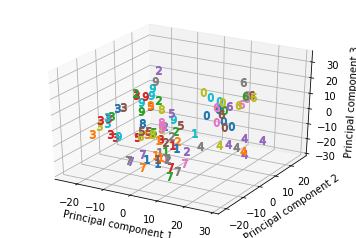

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(100):
    ax.scatter(
        pca_images[i, 0],
        pca_images[i, 1],
        pca_images[i, 2],
        marker=r'${}$'.format(labels[i]),
        s=64)

ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
ax.set_zlabel('Principal component 3')

图 6-3 PCA 预测 MNIST 数据的子集。标记对应于图像标签。

前 6 个投影图像的图片显示在[图 6-3 ](http://https://www.safaribooksonline.com/library/view/feature-engineering-for/9781491953235/ch06.html#fig-mnist-pca)的 3D 图中。标记对应于标签。前三个主成分大约占数据集总差的 40%。这绝不是完美的，但它允许方便的低维可视化。我们看到 PCA 组类似数字彼此接近。数字 0 和 6 位于同一区域，如同 1 和 17，3 和 9。该空间大致分为 0，4 和 6 一侧，其余数字是其他类的。

由于数字之间有相当多的重叠，因此很难清楚的将它们在投影空间中使用线性分类器分开。因此，如果任务是分类手写数字并且选择的模型是一个线性分类器，前三个主成分不足以作为功能。尽管如此有趣的是只有 3 个可以捕获多少个 64 维数据集尺寸。

## 白化和 PCA

由于目标函数中的正交性约束，PCA 变换产生了很好的附带作用：转换后的特征不再相关。再换句话说，特征向量对之间的内积是零。这很容易使用奇异向量的正交性来证明这一点：结果是包含奇异值的平方的对角矩阵表示每个特征向量与其自身的相关性，也称为其 L2 范数。

有时候，将特征的比例标准化为1.在信号中是有用的处理方式，这就是所谓的*白化*。 它产生了一组与自身具有单位相关性，并且彼此之间的相关性为零的结果。在数学上，*白化*可以通过将 PCA 变换乘以反奇异值。

公式 6-24 PCA 白化

$$
W_{\text {white}}=V_{k} \Sigma_{k}^{-1}
$$
$$
Z_{\text {white}}=X V_{k} \Sigma_{k}^{-1}=U \Sigma V^T V_{k} \Sigma_{k}^{-1}=U_{k}
$$

白化与维度降低无关；可以独立执行不受其他的干扰。例如，零相分量分析（ZCA）（Bell 和 Sejnowski，1996）是一种与 PCA 密切相关的白化转化，但事实并非减少特征的数量。ZCA 白化使用全套主要特征$V$ 没有减少，并且包括一个额外的乘法回到$V^T$)。

公式 6-25 ZCA 白化

$$
W_{\text {ZCA}}=V\Sigma^{-1}V^T
$$

$$
Z_{\text {zca}}=X V\Sigma^{-1}V^T=U \Sigma V^T V \Sigma^{-1}=U
$$


简单的 PCA 投影（[公式 6-19](https://www.safaribooksonline.com/library/view/feature-engineering-for/9781491953235/ch06.html#pca-projection)）在新特征中产生坐标空间，主成分作为基础。这些坐标表示只有投影向量的长度，而不是方向。乘以主成分给我们的长度和方向。另一个有效解释是，多余的乘法将坐标旋转回原点原始特征空间。（$V$是正交矩阵，并且正交矩阵旋转他们的输入不拉伸或压缩）。所以 ZCA 白化产生的数据尽可能接近原始数据（欧几里德距离）。

## 主成分分析的局限性

当使用 PCA 进行降维时，必须解决使用多少个主成分（$k$）的问题。像所有的超参数一样，这个数字可以根据最终模型的质量进行调整。但也有启发式算法不涉及高度的计算方法。

一种可能性是选择`k`来解释总方差的所需比例。（该选项在 scikit-learn 软件包的 PCA 中可用）投影到第$k$个分量上：$\left\|X_{V_{k}}\right\|^{2}=\left\|u_{k} \sigma_{k}\right\|^{2}=\sigma_{k}^{2}$，这是正方形 $X$的第$k$个最大奇异值。$a$的奇异值的有序列表矩阵被称为其频谱。因此，为了确定要使用多少个成分，人们可以对数据矩阵进行简单的频谱分析并选择阈值保留足够的差异。

## 基于占用方差的k选择

要保留足够的成分覆盖数据总方差的80%，请这样选择$k$：$$
\frac{\sum_{i=1}^{k} \sigma_{i}^{2}}{\sum_{i=1}^{d} \sigma_{i}^{2}} \geq 0.8
$$

另一种选择$k$的方法涉及数据集的固有维度。这个是一个更朦胧的概念，但也可以从频谱中确定。基本上，如果谱包含一些很大的奇异值和一些小奇异值，那么可能只是收获最大的奇异值并丢弃其余的值。有时候其余的频谱不是很小，但头部和尾部值之间有很大差距。这也是一个合理的截止点。 该方法需要光谱进行视觉检查，因此不能作为自动化管线的一部分执行。

对 PCA 的一个关键批评是转变相当复杂，并且结果因此很难解释。主成分和投影向量是真实的价值，可能是积极的或消极的。主成分是（居中）行的基本线性组合，以及投影值为列的线性组合。例如，在股票申报中，每个因素都是股票收益时间片的线性组合。那是什么意思？学习因素很难附加人为的理解原因。因此，分析师很难相信结果。如果你不能解释你为什么正在把数十亿其他人的钱放在特定的股票上，你可能会这样做将不会选择使用该模型。

PCA 在计算上是繁杂的的。它依赖于 SVD，这是一个昂贵的过程。计算一个矩阵的全 SVD 需要 $O(nd^2+d^3)$操作 [Golub 和 Van Loan，2012]，假设$n≥d$，即数据点比特征更多。即使我们只需要$k$个主成分，计算截断 SVD（$k$个最大奇异值和向量）仍然需要 $O((n+d)^2*k)= O(n^2k)$操作。这是令人望而生畏的当有大量数据点或特征时。

以流媒体方式，批量更新或者从 PCA 执行 PCA是 很困难的完整数据的样本。SVD 的流式计算，更新 SVD 和从一个子样本计算 SVD 都是很难研究的问题。算法存在，但代价是精度降低。一个含义是人们应该期待将测试数据投影到主成分上时代表性较低在训练集上找到。随着数据分布的变化，人们不得不这样做重新计算当前数据集中的主成分。

最后，最好不要将 PCA 应用于原始计数（字数，音乐播放次数，电影观看次数等）。这是因为这种计数通常包含在内大的异常值。（这个概率非常高，有粉丝观看了 314,582 次“指环王”，这让其余的人望而生畏计数）。正如我们所知，PCA 在特征中查找线性相关性。相关性和方差统计对大的异常值非常敏感; 单一大量的数据可能会改变很多。 所以，首先修剪是个好主意大数值的数据（“[基于频率的滤波](https://www.safaribooksonline.com/library/view/feature-engineering-for/9781491953235/ch03.html#sec-freq-filter)”）或应用缩放变换如 tf-idf（[第 4 章](https://www.safaribooksonline.com/library/view/feature-engineering-for/9781491953235/ch04.html#chap-tfidf)）或日志转换（“[日志转换](https://www.safaribooksonline.com/library/view/feature-engineering-for/9781491953235/ch02.html#sec-log-transform)”）。

## 用例

PCA 通过查找线性相关模式来减少特征空间维度功能之间。由于涉及 SVD，PCA 计算数千个功能的代价很高。但是对于少量的实值特征而言，它非常重要值得尝试。

PCA 转换会丢弃数据中的信息。因此，下游模型可能会训练成本更低，但可能不太准确。在 MNIST 数据集上，有一些观察到使用来自 PCA 的降维数据导致不太准确分类模型。在这些情况下，使用 PCA 有好处和坏处。

PCA 最酷的应用之一是时间序列的异常检测。Lakhina，Crovella 和 Diot [2004] 使用 PCA 来检测和诊断异常互联网流量。他们专注于数量异常情况，即当出现波动或波动时减少从一个网络区域到另一个网络区域的通信量。这些突然更改可能表示配置错误的网络或协调的拒绝服务攻击。无论哪种方式，知道何时何地发生这种变化对互联网都是有价值的运营商。

由于互联网上的交通总量非常之多，孤立的激增规模很小地区很难被发现。一个相对较小的主干链路处理很多交通。 他们的重要见解是，数量异常会影响到多个链接同时（因为网络数据包需要跳过多个节点才能到达他们的网络目的地）。将每个链接视为一项功能，并将每个链接的流量数量对待时间步骤作为测量。数据点是流量测量的时间片跨越网络上的所有链接。这个矩阵的主成分表明了网络上的整体流量趋势。其余的成分代表了剩余信号，其中包含异常。

PCA 也经常用于金融建模。在这些用例中，它作为一种类型工作因子分析，一组旨在描述观察结果的统计方法使用少量未观察因素的数据变异性。在因素分析中应用程序，目标是找到解释性成分，而不是转换数据。

像股票收益这样的财务数量往往是相互关联的。股票可以同时上下移动（正相关），也可以相反移动方向（负相关）。为了平衡波动和降低风险，投资组合需要多种不相关的股票其他。（如果篮子要下沉，不要把所有的鸡蛋放在一个篮子里）寻找强大的相关模式有助于决定投资策略。

股票关联模式可能在行业范围内。 例如，科技股可能会上涨并一起下跌，而当油价高企时，航空股往往下跌。 但行业可能不是解释结果的最好方式。 分析师也在寻找观察到的统计数据中意外的相关性 特别是*文体因素模型* [Connor，1995] 在个体股票时间序列矩阵上运行 PCA 返回寻找共同变化的股票。 在这个用例中，最终目标是主成分本身，而不是转换后的数据。

从图像中学习时，ZCA 可作为预处理步骤。在自然的图像中，相邻像素通常具有相似的颜色。ZCA 白化可以消除这种相关性，这允许后续的建模工作集中在更有趣的图像上结构。Alex Krizhevsky 的“[学习多层特征](http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf)”的论文图像“包含很好的示例，说明 ZCA 影响自然图片。

许多深度学习模型使用 PCA 或 ZCA 作为预处理步骤，但事实并非如此总是显示是必要的。在“Factored 3-Way Restricted Boltzmann Machines forModeling Natural Images”中，Ranzato et al，评论，“白化不是必要的，但加快了算法的收敛速度。在“[An Analysis of Single-Layer Networks in Unsupervised Feature Learning](http://ai.stanford.edu/~ang/papers/aistats11-AnalysisSingleLayerUnsupervisedFeatureLearning.pdf)”中，Coates 等人 发现 ZCA 白化是有帮助的对于某些号，但不是全部。（请注意，本文中的模型是无监督功能学习模型。 所以 ZCA 被用作其他功能的特征方法工程方法。方法的堆叠和链接在机器中很常见学习管道。）

## 总结

这结束了对 PCA 的讨论。关于 PCA 需要记住的两件事是其机制（线性投影）和目标（最大化方差预计数据）。该解决方案涉及协方差的特征分解矩阵，它与数据矩阵的 SVD 密切相关。人们还可以记住 PCA 的精神图像将数据挤压成像蓬松一样的煎饼可能。PCA 是模型驱动特征工程的一个示例。（应该立即怀疑当一个目标函数进入时，一个模型潜伏在背景中场景）。这里的建模假设是方差充分代表了包含在数据中的信息。等价地，该模型寻找线性特征之间的相关性。这在几个应用程序中用于减少相关性或在输入中找到共同因素。PCA 是一种众所周知的降维方法。但它有其局限性作为高计算成本和无法解释的结果。它作为一个预先定义好处理步骤，特别是在特征之间存在线性相关时。当被看作是一种消除线性相关的方法时，PCA 与其相关白化的概念。其表兄 ZCA 以可解释的方式使数据变白，但是不会降低维度。

## 参考书目

Bell, Anthony J. and Terrence J. Sejnowski. 1996. “Edges are the ‘Independent
Components’ of Natural Scenes.” Proceedings of the Conference on Neural Information Processing Systems (NIPS) .

Coates, Adam, Andrew Y. Ng, and Honglak Lee. 2011. “An Analysis of Single-Layer
Networks in Unsupervised Feature Learning." International conference on artificial intelligence and statistics .

Connor, Gregory. 1995. “The Three Types of Factor Models: A Comparison of Their Explanatory Power." Financial Analysts Journal 51, no. 3: 42-46. http://www.jstor.org/stable/4479845.

Golub, Gene H., and Charles F. Van Loan. 2012. Matrix Computations . Baltimore and London: Johns Hopkins University Press; fourth edition.

Krizhevsky, Alex. 2009. “Learning Multiple Layers of Features from Tiny Images.”
MSc thesis, University of Toronto.

Lakhina, Anukool, Mark Crovella, and Christophe Diot. 2004. “Diagnosing network-wide traffic anomalies.” Proceedings of the 2004 conference on Applications, technologies,architectures, and protocols for computer communications (SIGCOMM ’04). DOI=http://dx.doi.org/10.1145/1015467.1015492

Ranzato, Marc’Aurelio, Alex Krizhevsky, and Geoffrey E. Hinton. 2010. “Factored 3-Way Restricted Boltzmann Machines for Modeling Natural Images." Proceedings of the 13-th International Conference on Artificial Intelligence and Statistics (AISTATS 2010) 